# Navigation


### Introduction

Unity ML-agent library has a lot of simulation evnrionments to test intelligent agent models. This notebook solves the navigation task in an environment with bananas. The task is to move an agent to gain as many scores as possible by obtaining yellow bananas and avoiding purple ones. The agent uses a convention model(DQN) to learn an intelligent behavior to meet the objective. 
All the code is self contained in a notebook for a potential modification of any logic. Each component is separated to its own cell, so it can be easily written to a separate file using "%writefile" if necessary

---


### 1. Environment
#### Requirements
- Linux based OS
- Python (dependency is listed in requirements.txt)
- [Linux unity banana environment](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)

The following code will import modules and packages required to train and evaluate a DQN model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# Unzip the banana environment file and pass the path of "Banana.x86_64" to UnityEnvironment as an argument
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### The environment spec
- Number of agent: 1
- State space: 37 dimensional vector
- Action space: 4 discrete numbers (0: forward, 1: backward, 2: left, 3: right)
- Reward: +1: yellow banana, -1: purple banana

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 2. Implementation

#### Model
- **Description**
    - Standard fully-connected NN with a Batchnorm layer and ReLU activation. This model is used to evaluate Q values given a state.
- **Architecture**
    - 2 Hidden layers (128, 64 nodes)
    - 1 Output layer (4 nodes)
    - Each hidden layer uses ReLU and Batchnorm1d
    - Final output layer is a single linear layer without any activation
- **Discussion**
    - The initial hidden layer expanded the number of nodes for exploring rich feature space
    - ReLU and Batchnorm layer are used for efficient training
    - Final output layer doesn't use any activation because only the relative scale matters to select an action
 

#### Buffer
- **Description**
    - Replay buffer used in a DQN algorithm. It is a standard deque with a sampling function
- **Interface**
    - Initialization
        - sz: Replay buffer size
        - pf: Probability function for sampling
    - put(obj): Stored obj in a replay buffer
    - sample(n): Sample n objects from a replay buffer
    - update_pf(pf): Update the probability function pf
- **Discussion**
    - pf can be used for prioritized experience replay
    - It was used to explore the potential benefit of the skew in experience sampling, but was default to uniform sampling

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Model(nn.Module):
    """
    NN model used to evalate Q values of all possible actions given a state
    """
    def __init__(self, nfs = [37, 128, 64, 4]):
        super().__init__()
        self.nfs = nfs
        
        dr = nn.Dropout()
        layers = []
        for nif, nof in zip(self.nfs[:-2], self.nfs[1:-1]):
            layers.append(nn.Linear(nif, nof))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(nof))
#             layers.append(dr)
        
        self.layers = nn.Sequential(*layers)
        self.olin = nn.Linear(self.nfs[-2], self.nfs[-1])
    
    def forward(self, x):
        x = x.clone()
        x[:, :-1] -= 0.5
        
        f = self.layers(x)
        logits = self.olin(f)
        
        return logits

In [4]:
class Buffer:
    """
    Replay buffer implemented with a deque.
    """
    def __init__(self, sz=10000, pf=lambda x: 1):
        self.buf = deque(maxlen=sz)
        self.px = deque(maxlen=sz)
        self.temp = []
        self.pf = pf
        
    def update_pf(self, pf=lambda x: 1):
        self.pf = pf
        
    def put(self, sars):
        self.temp.append(sars)
        if sars[2] != 0:
            self.buf.extend(self.temp)
            self.px.extend([self.pf(x) for x in range(-len(self.temp) + 1, 1)])
#             newbuf = self.temp[np.random.randint(self.pf//70):self.pf:int(self.pf//70)]
#             self.buf.extend(newbuf)
#             self.px.extend([1 for _ in range(len(newbuf))])
            self.temp.clear()
    
    def sample(self, n=64):
        bufsz = len(self.buf)
        assert bufsz == len(self.px)
        n = bufsz if bufsz <= n else n
        idxs = np.random.choice(range(bufsz), n, replace=False, p=(self.px / np.sum(self.px)))
        samples = [self.buf[i] for i in idxs]
        
        states, actions, rewards, nstates = zip(*samples)
        return states, actions, rewards, nstates
    
    def __len__(self):
        return len(self.buf)
    
    def clear(self):
        self.temp = []

#### Training
- **Description**
    - Standard DQN training algorithm
- **Detail**
    1. Initialize a model and hyperparameters
    2. The model (agent) interacts with the banana Unity environment to collect tuple (state, action, reward, next-state)
    3. The collected tuples (experiences) are stored in a replay buffer
    4. The experience is randomly batch-sampled every 4 steps("train_step") and used to train the NN model
    5. 2-4 are repeated until the average score(return) reaches the objective score (13)
- **Hyperparameters**

|name|value|description|
|--|--|--|
|n_episodes|3000|Max number of episodes to explore|
|max_t|3000|Max number of time steps of each episode|
|bn|64|Training batch size|
|gamma|0.99|Return discounting factor|
|eps, eps_decay, eps_min|1.0, 0.999, 0.05|Random action exploration parameters|
|tau, tau_decay, tau_min|0.001, 0.9999, 0.001|Target network soft-update parameters|
|train_step|4|Frequency of the training|

In [12]:
# Number of episodes, Maximum time steps of an episode, Sample batch size
n_episodes = 3000
max_t = 3000
bn = 64


gamma = 0.99   # Discount factor
eps = 1.       # Exploration parameter
eps_decay = 0.999; eps_min=0.05
tau = 0.001    # Target network soft-update
tau_decay = 0.9999; tau_min=0.001
train_step = 4 # Frequency of the training

In [10]:
%%time
q_current = Model().to(device)
q_target = Model().to(device)
opt = optim.Adam(q_current.parameters())

# n_horizon=np.max([70, bn])
# replay_buf = Buffer(pf=lambda x: np.max([0, x+n_horizon]))
replay_buf = Buffer(pf=lambda x: 1)
# short_buf = deque(maxlen=10)
scores = []


for i in range(n_episodes):
    if i >= 130 and i % 50 == 49:
        avg_score = np.mean(scores[-100:])
        print(f"Episode no: {i}, Average score: {avg_score}")
#         replay_buf.update_pf(lambda x: np.max([0, x + (n_horizon * (i // 50 + 2))]))
#         short_buf = deque(maxlen = 10 * (i//30 + 2))

        if avg_score >= 13:
            torch.save(q_current.state_dict(), "q_current.pth")
            torch.save(q_target.state_dict(), "q_target.pth")
            print("Models are saved and training is finished")
            break
    
    
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
  
    rewards = []
    for t in range(max_t):
        st = torch.tensor(state.reshape(1,-1), dtype=torch.float, device=device)
        
        #####################################################
        # Interact with environment (eps: exploration ratio)
        #####################################################
        q_current.eval()
        with torch.no_grad():
            action = (q_current(st).argmax(1).item() 
                      if np.random.random() >= np.max([eps, eps_min]) 
                      else np.random.randint(action_size))
        q_current.train()
        
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
#         if (t >= 10 and np.sum(rewards[-len(short_buf):]) == 0 and 
#             np.any(np.vstack(short_buf)[:, :-2].dot(state[:-2]) >= 7)):
#             reward = -1
        done = env_info.local_done[0]                  # see if episode has finished
        
        rewards.append(reward)
        replay_buf.put((state, action, reward, next_state))
#         replay_buf.put((state, action, reward - 5*int(reward == 0 and done), next_state))
#         short_buf.append(state)
        
        ################################################################################
        # Training (Loss: MSE, tau: ratio of parameters to be mixed with target network)
        ################################################################################
        if t % train_step == 0 and len(replay_buf) >= 128:
            ss, aa, rr, nss = replay_buf.sample(bn)
            aa = torch.tensor(aa, dtype=torch.long, device=device).view(-1,1)
            ss, rr, nss = [torch.tensor(arr, dtype=torch.float, device=device).view(len(arr), -1) 
                           for arr in (ss, rr, nss)]
            curq = q_current(ss).gather(1, aa)
            tgtq = rr + gamma * q_target(nss).detach().max(1)[0].view(-1,1)
            
            loss = F.mse_loss(curq, tgtq)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            mixr = np.max([tau, tau_min])
            for tparam, cparam in zip(q_target.parameters(), q_current.parameters()):
                tparam.data.copy_(mixr * cparam.data + (1-mixr) * tparam.data)
            tau *= tau_decay
        
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        
        if done:                                       # exit loop if episode finished
            replay_buf.clear()
#             short_buf.clear()
            break
            
    eps *= eps_decay
    scores.append(score)

Episode no: 149, Average score: 0.05
Episode no: 199, Average score: 0.28
Episode no: 249, Average score: 0.56
Episode no: 299, Average score: 0.86
Episode no: 349, Average score: 1.1
Episode no: 399, Average score: 1.59
Episode no: 449, Average score: 2.2
Episode no: 499, Average score: 2.39
Episode no: 549, Average score: 2.44
Episode no: 599, Average score: 2.84
Episode no: 649, Average score: 3.59
Episode no: 699, Average score: 4.51
Episode no: 749, Average score: 5.14
Episode no: 799, Average score: 4.74
Episode no: 849, Average score: 4.53
Episode no: 899, Average score: 5.42
Episode no: 949, Average score: 6.71
Episode no: 999, Average score: 7.53
Episode no: 1049, Average score: 7.67
Episode no: 1099, Average score: 8.08
Episode no: 1149, Average score: 8.05
Episode no: 1199, Average score: 7.69
Episode no: 1249, Average score: 8.08
Episode no: 1299, Average score: 8.64
Episode no: 1349, Average score: 8.87
Episode no: 1399, Average score: 8.97
Episode no: 1449, Average score:

### 3. Results

The following 2 charts show the scores of the agent as it trains. (X: # episodes, Y: Score of each episode) <br>
A few interesting observations are
- The score variance increases as it trains. This means that the agent is specialised and not robust against different conditions
- The average score generally increases, but the improvement slope decreases. This is natural because the agent can learn a few simple tricks to get some scores, but it is difficult to learn a long-running strategy to get high scores. 

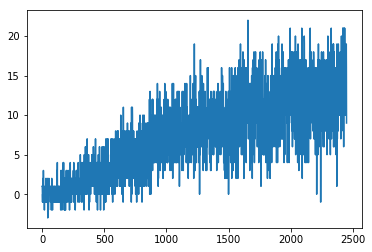

In [15]:
plt.plot(scores)

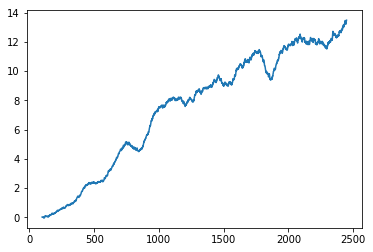

In [16]:
pd.Series(scores).rolling(100).mean().plot()

#### Agent Testing

In [22]:
q_current.load_state_dict(torch.load('q_current.pth'))
q_network = q_current

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

rewards = []
states = []
for t in range(max_t):
    st = torch.tensor(state.reshape(1,-1), dtype=torch.float, device=device)

    q_network.eval()
    with torch.no_grad():
        action = q_network(st).argmax(1).item()
    q_network.train()

    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished

    rewards.append(reward)
    states.append(state)

    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step

#     if t >= 50 and np.any([(states[-10][:-2] * t[:-2]).sum() >= 7 for t in states[-20:]]):
#         break
    if done:                                       # exit loop if episode finished
        break

    
print("Score: {}".format(score))

Score: 16.0


In [23]:
env.close()

### 4. Future work

1. Regardless of the shown scores, the actual agent's actual behavior can be different from ideal. The model and training can be debugged to find out typical behavioral issues and can be improved by tweaking an algorithm. The following general principles can be applied for the improvement
    - Reward reshaping to give more guidance to the agent
    - Encode characteristics of observation into the model architecture to better utilize it


2. General improvements of RL model can be tried and compared against the simple DQN algorithm used in this notebook


3. Replay buffer can be improved with a careful design of dynamic sampling pdf. Some of the information to be used are
    - Difference of return expections from current to next step (Typical Experience Prioritisation)
    - Experience sample's distance from the learning signal(reward)